In [0]:
import numpy as np
import pandas as pd
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_df = pd.read_csv('/content/drive/My Drive/Semester 7/Machine Learning/train.csv',index_col="tripid")

In [4]:
train_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,correct
213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,correct
213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,correct


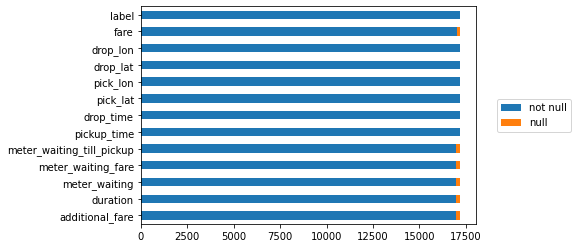

In [5]:
ax = pd.DataFrame({'not null': train_df.count(),
                   'null': train_df.isnull().sum()}).plot.barh(stacked=True)

ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5)
)

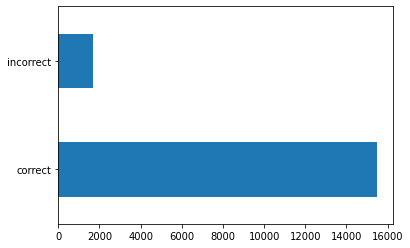

In [6]:
train_df['label'].value_counts().plot.barh()

In [0]:
from sklearn.preprocessing import label_binarize, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

RANDOM_SEED = 5    # Set a random seed for reproducibility!

In [0]:
def preprocessTrainData(train_df):
    #labels
    labels_df = train_df.loc[:, train_df.columns == 'label']
    
    labels_df = pd.DataFrame(label_binarize(labels_df, classes=['incorrrect', 'correct']))
    
    labels_df.columns = labels_df.columns
    labels_df.index = labels_df.index
    
    # features
    features_df = train_df.drop(columns=['label'])
    
    numeric_cols = features_df.columns[features_df.dtypes != "object"].values
    
    non_numeric_cols = features_df.columns[features_df.dtypes == "object"].values
    
    #numeric
    scaler = RobustScaler()
    features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])

    imputer = SimpleImputer(strategy='mean')
    features_df[numeric_cols] = imputer.fit_transform(features_df[numeric_cols])

    #date time
    features_df['pickup_time'] = pd.to_datetime(features_df['pickup_time'])
    features_df['drop_time'] = pd.to_datetime(features_df['drop_time'])
    
    features_df['pickup_day_of_week'] = features_df['pickup_time'].dt.day_name()
    features_df['drop_day_of_week'] = features_df['drop_time'].dt.day_name()
    
    features_df['pickup_hour'] = features_df['pickup_time'].dt.hour
    features_df['drop_hour'] = features_df['drop_time'].dt.hour
    
    features_df = pd.get_dummies(features_df, columns = ['pickup_day_of_week', 'drop_day_of_week'])
    
    features_df = features_df.drop(columns=['pickup_time','drop_time'])
    
    return features_df, labels_df

In [0]:
features_df, labels_df = preprocessTrainData(train_df)

In [0]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.2,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [0]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
y_pred = rf.predict(X_eval)
print('F1 score: {:.6f}'.format(f1_score(y_eval, y_pred)))
print('F1 score: {:.6f}'.format(f1_score(y_eval, y_pred, average='macro')))

F1 score: 0.965809
F1 score: 0.763147


In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = [
{'n_estimators': [10, 25], 'max_features': [5, 10], 
 'max_depth': [10, 50, None], 'bootstrap': [True, False]}
]

grid_search_forest = GridSearchCV(rf, param_grid, cv=10, scoring='f1_macro', n_jobs = -1)
grid_search_forest.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [0]:
#find the best model of grid search
grid_search_forest.best_params_

{'bootstrap': False, 'max_depth': None, 'max_features': 10, 'n_estimators': 10}

In [0]:
grid_best= grid_search_forest.best_estimator_.predict(X_eval)

In [0]:
print('F1 score: {:.6f}'.format(f1_score(y_eval, grid_best)))
print('F1 score: {:.6f}'.format(f1_score(y_eval, grid_best, average='macro')))

F1 score: 0.965999
F1 score: 0.797879


In [0]:
rf2 = RandomForestClassifier(bootstrap = False,
 max_depth= 50,
 max_features = 10,
 min_samples_split = 3,
 n_estimators = 200)

In [0]:
rf2.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
y_pred_2 = rf2.predict(X_eval)
print('F1 score: {:.6f}'.format(f1_score(y_eval, y_pred_2)))
print('F1 score: {:.6f}'.format(f1_score(y_eval, y_pred_2, average='macro')))

F1 score: 0.970291
F1 score: 0.812351


In [0]:
test_features_df = pd.read_csv('/content/drive/My Drive/Semester 7/Machine Learning/test.csv',index_col="tripid")
test_features_df = pd.read_csv('/content/drive/My Drive/Semester 7/Machine Learning/test.csv',index_col="tripid")

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 400, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(30, 70, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [2,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

pprint(random_grid)

{'max_depth': [30, 50, 70],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [2, 5],
 'n_estimators': [150, 212, 275, 337, 400]}


In [0]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 10, verbose=2, random_state=42, n_jobs = 8, scoring='f1_macro')
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed: 10.9min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              

In [0]:
random_best= rf_random.best_estimator_.predict(X_eval)

#print result
print('F1 score: {:.6f}'.format(f1_score(y_eval, random_best)))
print('F1 score macro: {:.6f}'.format(f1_score(y_eval, random_best, average='macro')))

F1 score: 0.966458
F1 score macro: 0.765749


In [0]:
def preprocessTestData(test_features_df):
    features_df = test_features_df
    
    numeric_cols = features_df.columns[features_df.dtypes != "object"].values
    
    non_numeric_cols = features_df.columns[features_df.dtypes == "object"].values
    
    #numeric
    scaler = RobustScaler()
    features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])

    imputer = SimpleImputer(strategy='mean')
    features_df[numeric_cols] = imputer.fit_transform(features_df[numeric_cols])

    #date time
    features_df['pickup_time'] = pd.to_datetime(features_df['pickup_time'])
    features_df['drop_time'] = pd.to_datetime(features_df['drop_time'])
    
    features_df['pickup_day_of_week'] = features_df['pickup_time'].dt.day_name()
    features_df['drop_day_of_week'] = features_df['drop_time'].dt.day_name()
    
    features_df['pickup_hour'] = features_df['pickup_time'].dt.hour
    features_df['drop_hour'] = features_df['drop_time'].dt.hour
    
    features_df = pd.get_dummies(features_df, columns = ['pickup_day_of_week', 'drop_day_of_week'])
    
    features_df = features_df.drop(columns=['pickup_time','drop_time'])
    
    return features_df

In [0]:
test_features_df = preprocessTestData(test_features_df)

In [0]:
test_pred = rf2.predict(test_features_df)
test_pred

array([1, 1, 1, ..., 1, 1, 1])

In [0]:
submission_df = pd.read_csv('/content/drive/My Drive/Semester 7/Machine Learning/sample_submission.csv',index_col="tripid")
submission_df

,prediction
tripid,
213284604,1
213286352,0
213293973,0
213294622,1
213298687,1
...,...
222856243,1
222857785,0
222858416,0


In [0]:
test_features_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_hour,drop_hour,pickup_day_of_week_Friday,pickup_day_of_week_Monday,pickup_day_of_week_Saturday,pickup_day_of_week_Sunday,pickup_day_of_week_Thursday,pickup_day_of_week_Tuesday,pickup_day_of_week_Wednesday,drop_day_of_week_Friday,drop_day_of_week_Monday,drop_day_of_week_Saturday,drop_day_of_week_Sunday,drop_day_of_week_Thursday,drop_day_of_week_Tuesday,drop_day_of_week_Wednesday
tripid,,,,,,,,,,,,,,,,,,,,,,,,,,
213284604,0.0,-0.049451,-0.241633,0.208494,0.678571,-0.387450,-0.278308,-0.673971,-0.189070,0.391381,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
213286352,0.0,2.761200,-0.313469,0.000000,0.169643,-0.009433,-0.307776,-1.747980,0.708107,7.838393,1,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0
213293973,0.0,0.481403,0.453878,0.226393,-0.437500,0.038444,-0.575171,-0.048285,-0.034706,0.871799,5,5,0,0,1,0,0,0,0,0,0,1,0,0,0,0
213294622,0.0,-0.439983,-0.326531,0.000000,1.125000,-0.682503,0.448568,-0.534391,0.398342,-0.227663,5,5,0,0,1,0,0,0,0,0,0,1,0,0,0,0
213298687,0.0,-0.142434,0.901224,1.053218,-0.026786,0.323794,0.136426,0.351418,-0.112406,-0.259086,7,7,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,0.0,0.625951,1.022041,2.114518,-0.616071,-0.306642,0.613370,-0.285680,0.198394,0.846478,21,21,0,1,0,0,0,0,0,0,1,0,0,0,0,0
222857785,0.0,0.334320,-0.117551,0.000000,0.473214,-0.003308,0.710505,0.027139,-0.044030,0.806890,21,22,0,1,0,0,0,0,0,0,1,0,0,0,0,0
222858416,0.0,-0.477177,-0.195918,0.279661,0.187500,-0.276505,0.082947,-0.368152,0.062678,-0.418170,22,22,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [0]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

In [0]:
# Save predictions to submission data frame
submission_df["prediction"] = test_pred

submission_df

,prediction
tripid,
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1
...,...
222856243,1
222857785,1
222858416,1


In [0]:
submission_df['prediction'] = submission_df['prediction'].astype(int)

In [0]:
submission_df.to_csv('/content/drive/My Drive/Semester 7/Machine Learning/submission2.csv', index=True)